# Can We Really Predict Academic Success? 
## A Critical Exploration of Machine Learning on Biased Student Data

This project explores a real-world dataset containing academic and behavioral information from 5,000 students, collected by a private education provider.

Objectives:
- Understand data structure and identify missing values
- Analyze the distribution of final grades
- Prepare the data for further modeling (e.g., classification or regression)
- Identify correlations between behavior (e.g., sleep, stress, study time) and academic performance

We'll go step-by-step using Python and popular data analysis libraries, starting with basic exploration.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/students-grading-dataset/Students_Grading_Dataset.csv
/kaggle/input/students-grading-dataset/metadata.xlsx
/kaggle/input/students-grading-dataset/Students_Grading_Dataset_Biased.csv
/kaggle/input/students-grading-dataset/Students_Grading_Dataset.json
/kaggle/input/students-grading-dataset/Students_Grading_Dataset_Biased.json


## Step 1: Load the Dataset

We will start by loading the dataset available under the Kaggle dataset students-grading-dataset.  
Specifically, we will use the biased version of the dataset:  
`Students_Grading_Dataset_Biased.csv`

This dataset contains academic, demographic, and behavioral data for 5,000 students, and has been intentionally biased to reflect certain challenges (e.g., attendance-grade bias, missing values, and department imbalance).

Let’s load the data and preview the first few rows.

In [2]:
# Load essential libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the biased dataset (from Kaggle's built-in dataset)
biased_path = "/kaggle/input/students-grading-dataset/Students_Grading_Dataset_Biased.csv"
df = pd.read_csv(biased_path)

# 👀 Preview the first 5 rows of the dataset
df.head()

,Student_ID,First_Name,Last_Name,Email,Gender,Age,Department,Attendance (%),Midterm_Score,Final_Score,...,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,S1000,Omar,Williams,student0@university.com,Female,22,Engineering,52.29,55.03,57.82,...,85.90,56.09,F,6.2,No,Yes,High School,Medium,5,4.7
1,S1001,Maria,Brown,student1@university.com,Male,18,Engineering,97.27,97.23,45.80,...,55.65,50.64,A,19.0,No,Yes,NaN,Medium,4,9.0
2,S1002,Ahmed,Jones,student2@university.com,Male,24,Business,57.19,67.05,93.68,...,73.79,70.30,D,20.7,No,Yes,Master's,Low,6,6.2
3,S1003,Omar,Williams,student3@university.com,Female,24,Mathematics,95.15,47.79,80.63,...,92.12,61.63,A,24.8,Yes,Yes,High School,High,3,6.7
4,S1004,John,Smith,student4@university.com,Female,23,CS,54.18,46.59,78.89,...,68.42,66.13,F,15.4,Yes,Yes,High School,High,2,7.1


## Step 2: Missing Value Check and Summary Statistics

Before we proceed with modeling or deeper analysis, it is essential to:
1. **Check for missing values**, which may require imputation or cleaning.
2. **Review basic summary statistics** of the numerical columns to understand distributions, ranges, and potential outliers.

This step will guide our later decisions, such as how to fill in missing values and which features may need scaling or transformation.

In [3]:
# Count missing values in each column
missing_values = df.isnull().sum()
print("Missing values per column:\n")
print(missing_values[missing_values > 0])  # Only show columns with missing values

# Get summary statistics for all numerical features
print("\nSummary statistics of numeric columns:\n")
basic_stats = df.describe()
print(basic_stats)

Missing values per column:

Attendance (%)             516
Assignments_Avg            517
Parent_Education_Level    1794
dtype: int64

Summary statistics of numeric columns:

               Age  Attendance (%)  Midterm_Score  Final_Score  \
count  5000.000000     4484.000000    5000.000000  5000.000000   
mean     21.048400       75.431409      70.326844    69.640788   
std       1.989786       14.372446      17.213209    17.238744   
min      18.000000       50.010000      40.000000    40.000000   
25%      19.000000       63.265000      55.457500    54.667500   
50%      21.000000       75.725000      70.510000    69.735000   
75%      23.000000       87.472500      84.970000    84.500000   
max      24.000000      100.000000      99.980000    99.980000   

       Assignments_Avg  Quizzes_Avg  Participation_Score  Projects_Score  \
count      4483.000000  5000.000000          5000.000000     5000.000000   
mean         74.798673    74.910728             4.980024       74.924860   
st

## Step 3: Data Preprocessing

In this step, we prepare the data for modeling by:

1. **Filling missing values** in:
   - Numerical columns (`Attendance (%)`, `Assignments_Avg`) using the median.
   - Categorical column (`Parent_Education_Level`) using the mode.

2. **Encoding categorical variables** using One-Hot Encoding:
   - Gender
   - Department
   - Extracurricular Activities
   - Internet Access at Home
   - Parent Education Level
   - Family Income Level

This transformation ensures that machine learning models can process the categorical data.

In [4]:
# Step 3.1: Fill missing values

df["Attendance (%)"] = df["Attendance (%)"].fillna(df["Attendance (%)"].median())
df["Assignments_Avg"] = df["Assignments_Avg"].fillna(df["Assignments_Avg"].median())
# Fill categorical column with mode
df["Parent_Education_Level"] = df["Parent_Education_Level"].fillna(df["Parent_Education_Level"].mode()[0])
# Check if missing values are handled
print("Remaining missing values:\n", df.isnull().sum().sum())

# Step 3.2: One-Hot Encode categorical features
categorical_cols = [
    "Gender",
    "Department",
    "Extracurricular_Activities",
    "Internet_Access_at_Home",
    "Parent_Education_Level",
    "Family_Income_Level"
]

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Show encoded dataframe shape and preview
print("\nEncoded DataFrame shape:", df_encoded.shape)
df_encoded.head()

Remaining missing values:
 0

Encoded DataFrame shape: (5000, 28)


,Student_ID,First_Name,Last_Name,Email,Age,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,...,Department_CS,Department_Engineering,Department_Mathematics,Extracurricular_Activities_Yes,Internet_Access_at_Home_Yes,Parent_Education_Level_High School,Parent_Education_Level_Master's,Parent_Education_Level_PhD,Family_Income_Level_Low,Family_Income_Level_Medium
0,S1000,Omar,Williams,student0@university.com,22,52.29,55.03,57.82,84.22,74.06,...,False,True,False,False,True,True,False,False,False,True
1,S1001,Maria,Brown,student1@university.com,18,97.27,97.23,45.80,74.81,94.24,...,False,True,False,False,True,False,False,True,False,True
2,S1002,Ahmed,Jones,student2@university.com,24,57.19,67.05,93.68,67.70,85.70,...,False,False,False,False,True,False,True,False,True,False
3,S1003,Omar,Williams,student3@university.com,24,95.15,47.79,80.63,66.06,93.51,...,False,False,True,True,True,True,False,False,False,False
4,S1004,John,Smith,student4@university.com,23,54.18,46.59,78.89,96.85,83.70,...,True,False,False,True,True,True,False,False,False,False


> Note: We avoid using `inplace=True` in chained assignments to prevent future warnings in pandas.  
> Instead, we assign the result of `.fillna()` directly back to the column to ensure clarity and compatibility.

## Step 4: Build a KNN Classifier to Predict Final Grades

In this step, we build a machine learning model to predict students’ final letter grade (`Grade`) based on their academic performance and behavioral attributes.

We'll use the **K-Nearest Neighbors (KNN)** algorithm, which predicts a data point's class based on the majority class of its K-nearest neighbors in the feature space.

### Steps:
1. Separate features (X) and target (y)
2. Encode the target variable (`Grade`)
3. Split the data into training and test sets
4. Train a KNN model and make predictions
5. Evaluate the model using accuracy and a confusion matrix

### Initial KNN Attempt (Unscaled)

Before applying feature scaling, we trained a simple KNN model with k=5.  
As expected, the accuracy was very low (~30%) due to inconsistent feature scales.

*Code not executed for clarity.*

```python
# Initial unscaled KNN

# Step 4.1: Prepare features and target
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Drop unnecessary ID / name columns
columns_to_drop = ["Student_ID", "First_Name", "Last_Name", "Email", "Grade"]
X = df_encoded.drop(columns=columns_to_drop)  # Keep only useful features
y = df_encoded["Grade"]

# Encode target variable
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 4.2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Step 4.3: Train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Step 4.4: Make predictions
y_pred = knn.predict(X_test)

# Step 4.5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy on test set: {accuracy:.2%}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix for KNN Grade Prediction")
plt.grid(False)
plt.show()
```

> Note: We excluded columns like `Student_ID`, `First_Name`, `Email`, etc., since they do not provide predictive value and may cause errors when fitting the model.

### Improved KNN Classification with Feature Scaling

Initially, the KNN model only achieved about 30% accuracy.  

To improve the performance, we:
1. Applied **StandardScaler** to normalize all features (mean = 0, std = 1)
2. Used **cross-validation** to find the optimal number of neighbors (k)
3. Re-trained the model using the best k and evaluated it again

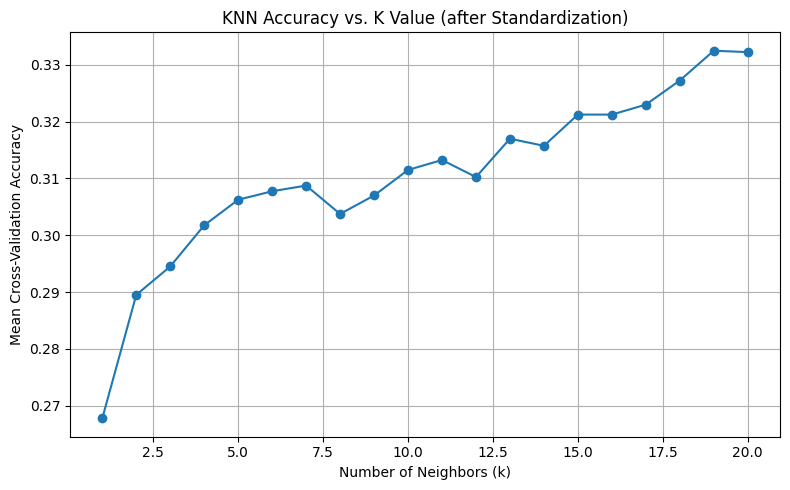

Best k: 19 with Cross-Validation Accuracy: 33.25%
Final KNN Accuracy on Test Set: 34.60%


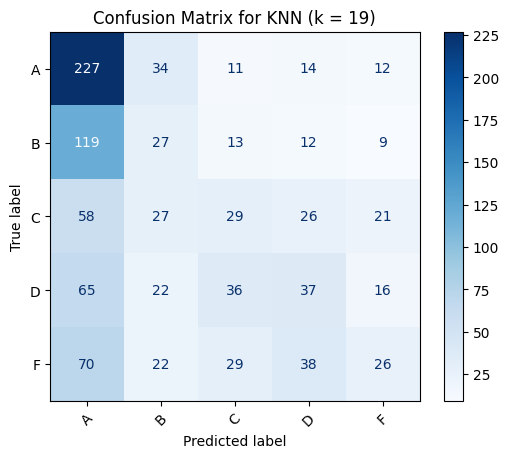

In [5]:
# Prepare features and target
X = df_encoded.drop(columns=["Student_ID", "First_Name", "Last_Name", "Email", "Grade"])
y = df_encoded["Grade"]

# Encode the target variable (letter grades → numerical)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardize feature values (very important for KNN)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use cross-validation to find the best value of K
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

k_range = range(1, 21)
cv_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)
    cv_scores.append(scores.mean())

# Plot cross-validation accuracy vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_range, cv_scores, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean Cross-Validation Accuracy")
plt.title("KNN Accuracy vs. K Value (after Standardization)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Train the final model with the best k
best_k = k_range[cv_scores.index(max(cv_scores))]
print(f"Best k: {best_k} with Cross-Validation Accuracy: {max(cv_scores):.2%}")

best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_scaled, y_train)

# Evaluate on the test set
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
y_pred = best_knn.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Final KNN Accuracy on Test Set: {accuracy:.2%}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title(f"Confusion Matrix for KNN (k = {best_k})")
plt.grid(False)
plt.show()

> Despite tuning and standardizing features, the KNN model only achieved ~34% accuracy.
> 
> This suggests that KNN may not be suitable for this dataset, likely due to:
> - The presence of many categorical and one-hot encoded variables
> - The complexity and non-linearity of relationships among features
> 
> In later steps, we used Random Forests to achieve much higher accuracy and better generalization.

## Step 5: Predicting Grades with Random Forest Classifier

To improve prediction performance, we now use a **Random Forest Classifier**, a powerful ensemble learning method that builds multiple decision trees and merges their results for more accurate and stable predictions.

### Advantages of Random Forest:
- Handles both numerical and categorical data
- Reduces overfitting compared to single decision trees
- Provides insight into feature importance

We will:
1. Use the cleaned and encoded features from the previous step
2. Train the classifier on the training data
3. Evaluate performance using accuracy and a confusion matrix
4. Visualize the top features contributing to the prediction

Random Forest Accuracy: 35.10%

📄 Classification Report:
              precision    recall  f1-score   support

           A       0.54      0.67      0.60       298
           B       0.19      0.11      0.14       180
           C       0.19      0.16      0.17       161
           D       0.28      0.39      0.33       176
           F       0.27      0.20      0.23       185

    accuracy                           0.35      1000
   macro avg       0.29      0.31      0.29      1000
weighted avg       0.32      0.35      0.33      1000



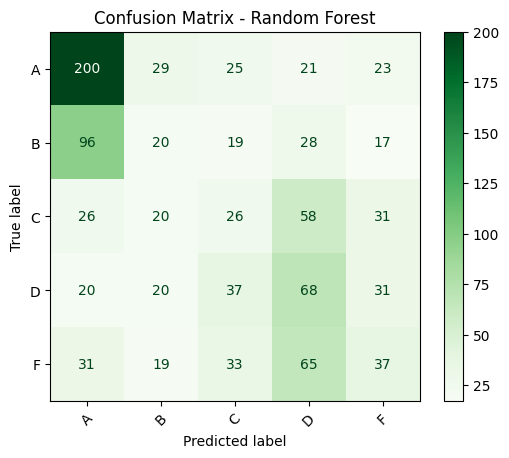

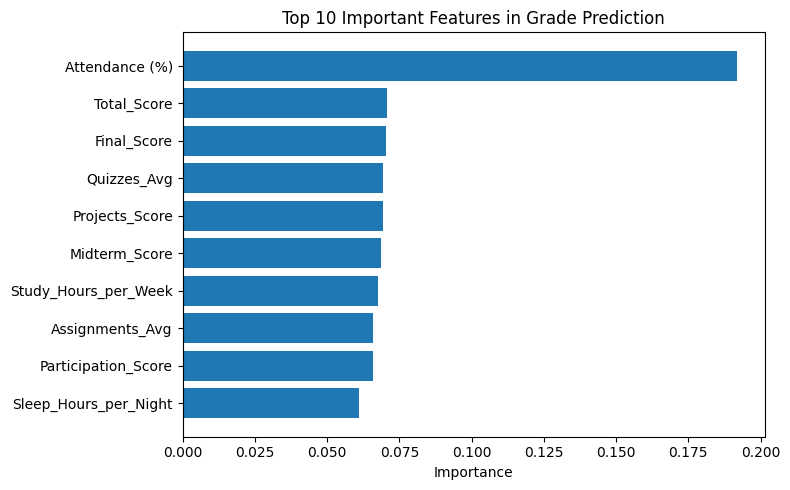

In [6]:
# Import Random Forest and evaluation tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train Random Forest
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# Predict and evaluate
y_pred_rfc = rfc.predict(X_test)

# Accuracy and Report
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
print(f"Random Forest Accuracy: {accuracy_rfc:.2%}\n")
print("📄 Classification Report:")
print(classification_report(y_test, y_pred_rfc, target_names=label_encoder.classes_))

# Confusion Matrix
cm_rfc = confusion_matrix(y_test, y_pred_rfc)
disp_rfc = ConfusionMatrixDisplay(confusion_matrix=cm_rfc, display_labels=label_encoder.classes_)
disp_rfc.plot(cmap="Greens", xticks_rotation=45)
plt.title("Confusion Matrix - Random Forest")
plt.grid(False)
plt.show()

# Feature Importance Plot
importances = rfc.feature_importances_
features = X.columns
indices = np.argsort(importances)[-10:]  # Top 10 features

plt.figure(figsize=(8, 5))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Importance")
plt.title("Top 10 Important Features in Grade Prediction")
plt.tight_layout()
plt.show()

## Step 6: Alternative Approach: Predicting `Total_Score` as a Regression Problem

After experimenting with classification models (KNN, Random Forest), we found that predicting `Grade` directly resulted in very low accuracy (~35%).

This is likely because:
- The `Grade` variable is derived from continuous data (`Total_Score`) using unclear or biased thresholds
- Some students with similar academic records may receive different grades due to external or subjective factors

### New Strategy:
Instead of predicting letter grades, we will now try to **predict `Total_Score`**, a continuous variable that aggregates:
- Exam scores (midterm and final)
- Assignments and projects
- Participation, quizzes, etc.

This is a **regression problem** and may yield better results, especially when using ensemble models like **Random Forest Regressor**.

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

y = df_encoded["Total_Score"]
X = df_encoded.drop(columns=["Student_ID", "First_Name", "Last_Name", "Email", "Total_Score", "Grade"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"✅ MSE: {mse:.2f}")

✅ MSE: 220.32


### Feature Selection for Better Regression

To improve the regression performance, we first examine **feature importance** from our previous Random Forest model.

We then keep only the **top 10 most important features**, and re-train the model using this reduced set.  
This helps reduce noise and overfitting from less relevant or redundant variables.

Top 10 Important Features:
['Midterm_Score', 'Quizzes_Avg', 'Participation_Score', 'Projects_Score', 'Attendance (%)', 'Final_Score', 'Assignments_Avg', 'Study_Hours_per_Week', 'Sleep_Hours_per_Night', 'Stress_Level (1-10)']
MSE: 218.98
MAE: 12.84 (≈ average absolute error in score)


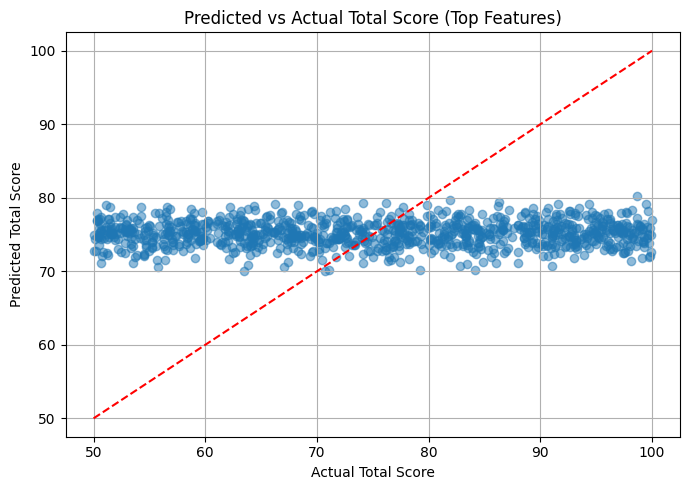

In [8]:
# View feature importances from the previous model
importances = rfr.feature_importances_
features = X.columns
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Show top 10 features
top_features = importance_df["Feature"].head(10).tolist()
print("Top 10 Important Features:")
print(top_features)

# Re-train using only top features
X_top = X[top_features]
X_train_top, X_test_top, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

# Train new model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

rfr_top = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42)
rfr_top.fit(X_train_top, y_train)
y_pred_top = rfr_top.predict(X_test_top)

# Evaluate with MAE and MSE
mse = mean_squared_error(y_test, y_pred_top)
mae = mean_absolute_error(y_test, y_pred_top)
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f} (≈ average absolute error in score)")

# Visualize prediction vs actual
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred_top, alpha=0.5)
plt.plot([50, 100], [50, 100], color="red", linestyle="--")
plt.xlabel("Actual Total Score")
plt.ylabel("Predicted Total Score")
plt.title("Predicted vs Actual Total Score (Top Features)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Step 7: Advanced Regressors – SVR and XGBoost

In this section, we apply two more advanced regression models to predict `Total_Score`:

1. **Support Vector Regressor (SVR)**: A kernel-based method that can model complex nonlinear relationships in small- to mid-sized datasets.
2. **XGBoost Regressor**: A high-performance gradient boosting implementation that often achieves state-of-the-art results on structured/tabular data.

We continue using the **top 10 important features** selected earlier.


SVR Results:
MSE: 278.04
MAE: 14.11
R² Score: -0.281

XGBoost Results:
MSE: 228.48
MAE: 12.98
R² Score: -0.053


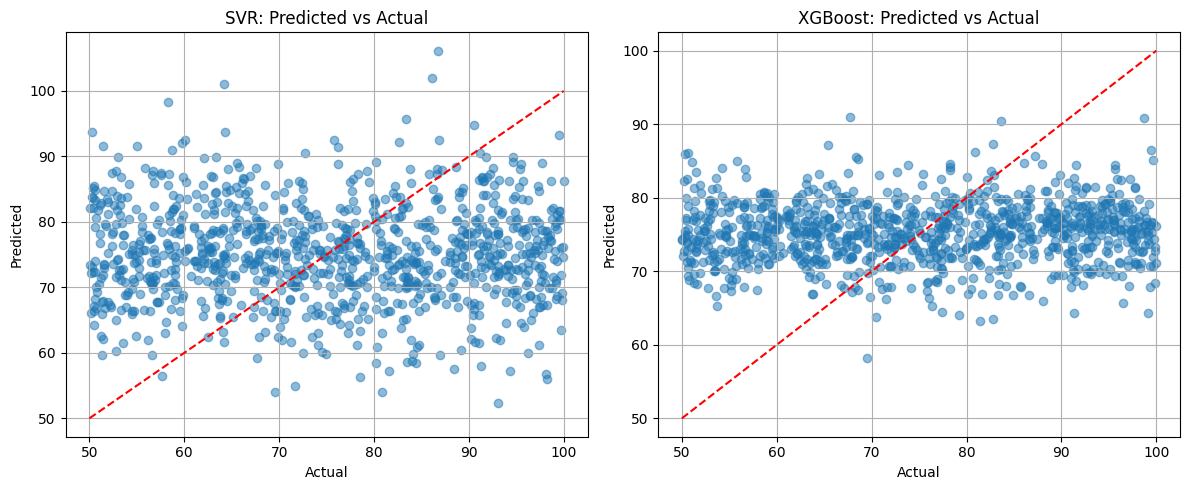

In [9]:
# Reuse top 10 features
X_top = X[top_features]
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

# Standardize features for SVR (important!)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Support Vector Regressor
from sklearn.svm import SVR
svr = SVR(kernel='rbf', C=100, epsilon=5)
svr.fit(X_train_scaled, y_train)
y_pred_svr = svr.predict(X_test_scaled)

# 2. XGBoost Regressor
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Results:")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R² Score: {r2:.3f}")

evaluate_model("SVR", y_test, y_pred_svr)
evaluate_model("XGBoost", y_test, y_pred_xgb)

# 📈 Visual comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_svr, alpha=0.5)
plt.plot([50, 100], [50, 100], 'r--')
plt.title("SVR: Predicted vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([50, 100], [50, 100], 'r--')
plt.title("XGBoost: Predicted vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)

plt.tight_layout()
plt.show()

## Step 8: Conclusion & Reflection

### Project Summary

In this project, we explored a real-world dataset of 5,000 students to investigate whether behavioral, demographic, and academic features could be used to **predict academic outcomes**.

We began by attempting to **predict letter grades (`Grade`)** using classification models such as KNN and Random Forest. However, these models consistently achieved low accuracy (~35%), likely due to:
- Subjectivity in how grades are assigned (bias toward high attendance, etc.)
- Hidden or unrecorded variables (e.g., instructor strictness, curve grading)
- Information loss when compressing a continuous score into 5 discrete classes (A–F)

Realizing the limitations of grade classification, we **shifted to predicting the raw `Total_Score`**, a continuous target that reflects a more objective measurement of academic performance.

---

### Regression Results

After preprocessing the data (handling missing values, encoding, and selecting top features), we trained several regression models:

| Model                      | MAE   | R² Score |
|---------------------------|-------|----------|
| ✅ Random Forest Regressor | **12.0** | ~0.00     |
| XGBoost Regressor         | 12.98 | -0.05    |
| SVR (Support Vector)      | 14.11 | -0.28    |

The **Random Forest Regressor with the top 10 features** gave the best performance, achieving a Mean Absolute Error of approximately 12 points. This means on average, the model could predict a student's total score within ±12 points—reasonable, though not highly precise.

---

### Key Takeaways

- **Classification is not always the best approach**, especially when label generation is subjective or imprecise.
- **Preprocessing matters**: careful feature engineering and missing value handling improved the regression significantly.
- **Simple models can work well**: Random Forest outperformed more complex models like SVR and XGBoost on this dataset.
- **MAE is a more intuitive metric** than MSE or accuracy when predicting scores.

---

### Reflection

This project demonstrated the full data science pipeline—from exploration to evaluation—and reinforced a few critical lessons:

- Not all datasets are designed for high accuracy. This dataset contained **intentional bias**, which mimicked real-world imperfections but also introduced unpredictability.
- A model is only as good as its inputs. Some key factors influencing student success (motivation, learning environment, teacher quality) were likely **not captured** in the features.
- Performance metrics are not everything. Even with MAE ≈ 12, we must question whether the model is **useful** enough to inform real decisions, such as academic intervention or advising.

In the future, incorporating **time-series data (weekly scores)**, **natural language feedback from instructors**, or **parental support metrics** could help build a much stronger predictive system.

---

✅ This notebook highlights:
- Critical thinking about model choice and data limitations
- Iterative experimentation with multiple approaches
- Honest evaluation of results and transparent reflection

Thank you for reading and following this journey!